In [31]:
import keras
import tensorflow as tf
from mlxtend.feature_extraction import PrincipalComponentAnalysis as PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm
import time
from mlxtend.preprocessing import standardize
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.metrics import accuracy
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import math
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
orbits = pd.read_csv('orbits.csv')
impacts = pd.read_csv('impacts.csv')
orbits=orbits.fillna(0)
impacts=impacts.fillna(0)

#d3=orbits.merge(impacts, left_on="Object Name", right_on="Object Name")
#d3 = pd.merge(orbits,impacts, how='inner', left_on="Object Name", right_on="Object Name")
orbitas=orbits["Object Name"]#.to_numpy()
impactos=impacts["Object Name"]#.to_numpy()

#PARA OBJECT CLASSIFICATION 1HOT
cat_encoder = OneHotEncoder()
Object_classification = cat_encoder.fit_transform(orbits[["Object Classification"]])
Object_classification=Object_classification.toarray()
#print(np.shape(Object_classification))
#print("HASTA AQUI ES EL OBJECT CLASIFICAITON 1HOT")


#\xa0 THIS MF
#print(orbitas.head())
nporbit=orbits.to_numpy()

#imputamos el unico nana que se volivo cero a la media de la columna
#print("DESDE AQUI")
#print(nporbit[6896,:])
nporbit[6896,-1]=np.mean(nporbit[:,-1])
#print(nporbit[6896,:])
#print("HASTA AQUI")

nporbit=np.c_[nporbit,Object_classification]
nimpacts=impacts.to_numpy()
print("nimpacts"+str(np.shape(nimpacts)))
data=nporbit[:np.size(nimpacts,0),:]
print("data "+str(np.shape(data)))
print("nporbit"+str(np.shape(nporbit)))
f=0
for h,k in impactos.iteritems():
    k=k.replace('(',"")
    k=k.replace(')',"")
    k=k.replace(' ',"")
    #print(k)
    which=False
    for i,j in orbitas.iteritems():
        j=j.replace('(',"")
        j=j.replace(')',"")
        j=j.replace('\xa0',"")
        if k==j:
            f+=1
            # on a new NP on ROW h add the pertinent register
            data[h]=nporbit[i,:]
            #print("association on "+str(h)+" on IMPACTOS"+" association on "+str(i)+" on ORBITAS")
            which=True
    if which==False:
        print("could not associate "+k+" at "+str(h))
            
print(" we have in common "+str(f))

#print(data)
db=np.c_[nimpacts,data]
#discard elements not inclucded or wrongly named 
db=np.delete(db, 100, 0)
db=np.delete(db, 330, 0)
db=np.delete(db, 680, 0)
#remove redundant columns or columns without information
db=np.delete(db,10, 1)#remove maximun torino scale
db=np.delete(db,10, 1)#remove the redundant Object name
Y=db[:,3]#get Y
db=np.delete(db,3, 1)#remove Y  from the X
db=np.delete(db,9, 1)#remove the oBJECT CLASIFICATION LABEL
#print(db[-1,:])
db=db[:,1:]#REMOVE THE NAMES SO WE ONLY HAVE NUMBERS
#print(db[-1,:])
u=0
for f in db:
    for r in f:
        if(math.isnan(r)):
            print(f)
            u+=1
    
print("THERE ARE "+str(u)+" NAN VALUEs ")
print("DB "+str(np.shape(db)))
#Y=Y.reshape(np.size(Y,0),1)
print("Y "+str(np.shape(Y)))
#normalize vars
scaler = MinMaxScaler()
scaler.fit(db)
db= scaler.transform(db)


nimpacts(683, 11)
data (683, 23)
nporbit(15635, 23)
could not associate 2017AR20 at 100
could not associate 99942Apophis2004MN4 at 330
could not associate 101955Bennu1999RQ36 at 680
 we have in common 680
THERE ARE 0 NAN VALUEs 
DB (680, 29)
Y (680,)


In [32]:
#FEAUTURE SELECTION 
#print(Y)
'''
print(db[-1,:])
print("DB sin seleccion de caracteristicas "+str(np.shape(db)))
#cat_encoder.categories_
#print(db[:,1:])
def select_features(n_features, fwd, fltg):
    #EL MODELO SEA SVM para como es de regresion se adapte a los datos
    model= svm.SVR(kernel='rbf',gamma=0.1,C=100)
    sfs = SFS(model,
           k_features=n_features, 
           forward=fwd,
           floating=fltg,
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=10)
    return sfs


sfs=select_features(10, True, False)
sfs=sfs.fit(db,Y)
index=sfs.k_feature_idx_
newdb=db[:,:len(index)]
#print(np.shape(newdb))
print("indices "+str(index))
vamos=0
for i in index:
    newdb[:,vamos]=db[:,i]
    vamos+=1
db=newdb


print(db[-1,:])
print("DB con seleccion de caracteristicas"+str(np.shape(db)))
'''
#FEATURE EXTRACTION
X = standardize(db)
ex =PCA(25)
ex =ex.fit(X)
X_ex =ex.transform(X)
db=X_ex
impacts.corr()
orbits.corr()

PARA EL GRADO 1 tenemos :


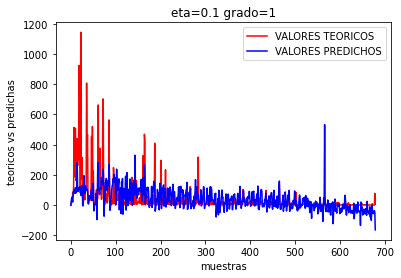

con eta=0.1 ,Error de validación: 5382.184591599703 +/- 10220.866656383694


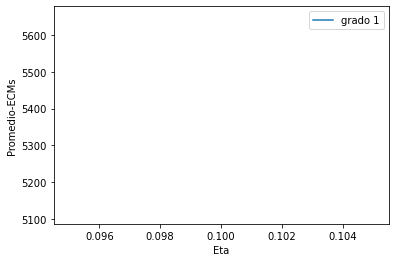

In [12]:
#REGRESION POLINOMIAL MULTIPLE
#Error cuadrático medio (criterio para el modelo de regresión polinomial)
def ECM(Y_est,Y):
    N = np.size(Y)
    ecm = sum((Y_est - Y)**2)/(2*N)
    return ecm 

#Modelo Regresión Múltiple
def regression(X, W):
    Yest = np.dot(X,W)    #con np.dot se realiza el producto matricial. Aquí X es dim [Nxd] y W es dim [dx1]
    return Yest           #La variable Yest contiene la salida de f(X,W)


#Potencia de polinomio
def potenciaPolinomio(X,grado):
    """
    Este método permite aumentar la matriz (base de datos de entrenamiento)
    de tal manera que se incluyan los términos con potencia mayores que 1
    de acuerdo al parámetro grado (M) que pase el usuario.
    """
    X2 = X
    
    if grado != 1:
        for i in range(2,grado+1):
            Xadd = X**i
            X2 = np.concatenate((X2, Xadd), axis=1)
    
    return X2

    
#Gradiente descendente para regresión polinomial
def gradiente_descendente(X,Y,grado,eta,iterations):
    
    """
    params:
    X: base de datos de entrenamiento (array de numpy)
    Y: variable de salida (array de numpy)
    grado: grado del polinomi (Natural mayor o igual a 1)
    eta: tasa de aprendizaje para el algoritmo de gradiente descendente
    (real mayor que cero. Ej: 0.001)
    iterations: número de iteraciones del algoritmo de gradiente descendente
    """
    
    #Se modifica la matriz de datos original de acuerdo al grado del polinomio ingresado para el modelo
    X = potenciaPolinomio(X,grado)
    
    #X es la matriz de datos extendida. W es el vector de parámetros del modelo
    #Extendemos la matriz
    unos = np.array([np.ones(np.size(X,0))])
    #Concatenamos el vector de unos con la matriz X
    X = np.concatenate((unos.T, X), axis=1)
    X = X.reshape(np.size(X,0),np.size(X,1))
    Y = Y.reshape(np.size(Y), 1)
    
    #Tomamos el número de variables del problema
    d = np.size(X,1)
    
    #Tomamos el número de muestras de la base de datos
    N = np.size(X,0)
    
    #Inicializamos el vector de parámetros aleatoriamente
    Want = np.zeros(d)
    Want = Want.reshape(np.size(Want),1)
    
    eta = eta
    
    iteraciones = iterations
    ecms = np.zeros(iteraciones)
    
    for iter in range(iteraciones):
        
        #error = ECM(regression(X,Want),Y)
        #ecms[iter] = error
        
        #Aquí debe completar el código con la regla de actualización de los
        #parámetros W. Tenga en cuenta los nombres de las variables ya creadas:
        #Want, X, Y
        Want=Want-(eta*(np.dot((regression(X,Want)-Y).T,X).T/N))
        #Nota: si usa la notación matricial esto puede hacerse en dos líneas de
        #código.
        
    W=Want
    #print ('Vector de parámetros del modelo:\n')
    #print (W)
    #print ('\nError Final = ' + str(np.min(ecms)))
    
    #Aquí debe completar el código para realizar la gráfica de ecms vs. iteraciones
    #ecms en el eje de las ordenadas (vertical); iteraciones en el eje de las abscisas.
    #print("iteraciones es "+str(iteraciones)+" ,ecs es "+str(ecms))
    #plt.plot(np.arange(iteraciones),ecms)
    #plt.ylabel("ECM")
    #plt.xlabel("iteraciones")
    #plt.show()
    return W
    




part=10
grados=[1]
iteraciones=1000
etas=[0.1]
for grado in grados:
    resultados=[]
    #graficamos por ese grado ,resultados vs etas
    print("PARA EL GRADO "+str(grado)+" tenemos :")
    for eta in etas:
        predichas=np.ones((np.size(db,0),1))
        error= np.ones(part)
        cuantos=0
        kf = KFold(n_splits=part)
        for train_index, test_index in kf.split(db):
            w=gradiente_descendente(db[train_index],Y[train_index],grado,eta,iteraciones)#TRAIN

            x_test=db[test_index]
            x_test=potenciaPolinomio(x_test,grado)
            unos = np.array([np.ones(np.size(x_test,0))])
            #Concatenamos el vector de unos con la matriz X
            x_test = np.concatenate((unos.T, x_test), axis=1)

            y_test=Y[test_index].reshape(np.size(Y[test_index]),1)
            yest=regression(x_test,w)#predict
            predichas[test_index]=yest
            #print("w es "+str(np.shape(w)))
            #print("x_test es "+str(np.shape(x_test)))
            #print("yest es "+str(np.shape(yest)))
            #print("Y es "+str(np.shape(y_test)))
            #print(yest)
            #print(y_test)
            error[cuantos]=ECM(yest,y_test)#calculate error
            cuantos+=1
            #print(error)
        x=np.size(Y)
        plt.title("eta="+str(eta)+" grado="+str(grado))
        plt.plot(np.arange(x), Y, color="red", label ='VALORES TEORICOS')
        plt.plot(np.arange(x), predichas,color="blue", label ='VALORES PREDICHOS')
        plt.xlabel("muestras")
        plt.ylabel("teoricos vs predichas")
        plt.legend()
        plt.show()
        print("con eta="+str(eta)+" ,Error de validación: "+str(np.mean(error)) + " +/- " + str(np.std(error)))
        resultados.append(np.mean(error))#print("ERROR PROMEDIO TOTAL :")
    ejex = np.array(etas)
    ejey = np.array(resultados)
    plt.plot(ejex,ejey,label="grado "+str(grado))
plt.ylabel("Promedio-ECMs")
plt.xlabel("Eta")
plt.legend()
plt.show()

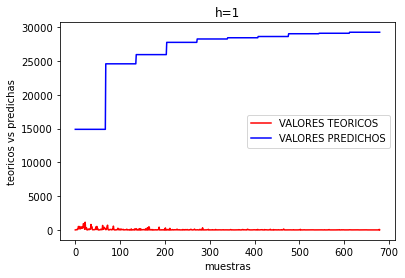

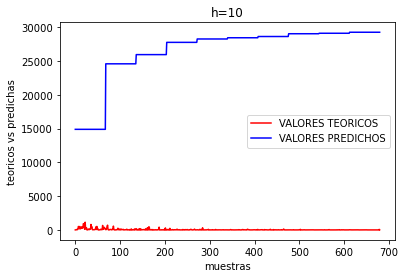

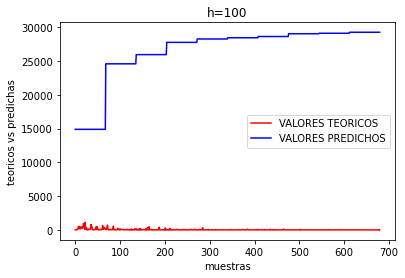

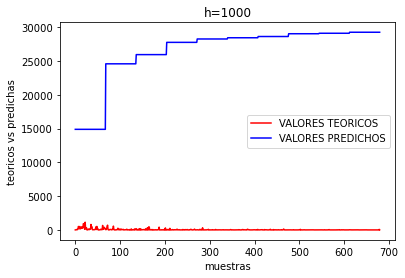

'lista=[1,2,3]\nlista2=[4,5,6]\nlista3=[7,8,9]\nlista4=[]\nfor i in lista:\n    for j in lista2:\n        for k in lista3:\n            #print (i,j,k)\n            lista4.append(i*j*k)\nprint(lista4)'

In [50]:
#VENTANA DE PARZEN NADARAYA-WATSON

#Método para calcular la distancia entre dos vectores
def dist_euclidiana(x1, x2):
    
    #Complete el código para calcular la distancia entre x1 y x2
    dist = np.sqrt(np.sum((x1-x2)**2))
    
    return dist

#Error cuadrático medio para los problemas de regresión
def ECM(Y_est,Y):
    N = np.size(Y)
    Y = Y
#Analice la variable de salida de la base de datos y observe porque se multiplica por 100
    Y_est = np.asarray(Y_est)
    ecm = np.sum((Y_est - Y)**2)/(2*N)
    return ecm

def kernel_gaussiano(x):
    return (1/np.sqrt(2*np.pi))*np.exp((-0.5)*x**2)

def Nadaraya_Watson(X_train, Y_train, X_val, Y_val, ancho_h):
        
    h = ancho_h
        
    Y_est = []
    for x1 in X_val:
        y_est = 0
        distances = []
        for x2 in X_train:
            distances.append(dist_euclidiana(x1,x2))
        
        #EN PARZEN ES X*-Xi O LAS DISTANCIAS ECUCLIDIANAS?
        
        #Tenga en cuenta que distances es una lista y 
        #la puede convertir a un arreglo con el método np.asarray (consulte)
        #Complete el codigo aquí
        #implemente la función de Nadaraya-Watson usando el kernel gaussiano 
        dis=np.asarray(distances)
        dis=dis.reshape(np.size(dis),1)
        #print(dis[:5])
        #print(np.shape(dis))
        #print(kernel_gaussiano(4))
        Y_train=Y_train.reshape(np.size(Y_train),1)
        #print(np.shape(Y_train))
        #print(kernel_gaussiano(dis/h))
        denominador=np.sum(kernel_gaussiano(dis/h))
        numerador=np.sum(np.dot(kernel_gaussiano(dis/h),Y_train.T))
        #print("NUMERADOR",numerador)
        #print("DENOMINADOR",denominador)
        y_est=numerador/denominador
        #print(y_est)
        Y_est.append(y_est)
    salida=np.array(Y_est)
    #Ytrain=Ytrain.reshape(np.size(Ytrain),1)
    salida=salida.reshape(np.size(salida,0),1)
    return salida#ECM(Y_est, Y_val)

kf = KFold(n_splits=10)




#list_h = np.arange(1,1000,5).tolist()

list_h = [ 1, 10,100,1000]
Errors_h = np.ones(len(list_h))
i = 0
predichas=np.ones((np.size(db,0),1))

for h in list_h:
    Errores = np.ones(10)
    j = 0
    for train_index, test_index in kf.split(db):
        Xtrain, Xtest = db[train_index], db[test_index]
        Ytrain, Ytest = Y[train_index], Y[test_index]  
        #Errores[j] = Nadaraya_Watson(Xtrain, Ytrain, Xtest, Ytest, h)
        predichas[test_index]=Nadaraya_Watson(Xtrain, Ytrain, Xtest, Ytest, h)
        j+=1
    x=np.size(Y)
    plt.title("h="+str(h))
    plt.plot(np.arange(x), Y, color="red", label ='VALORES TEORICOS')
    plt.plot(np.arange(x), predichas,color="blue", label ='VALORES PREDICHOS')
    plt.xlabel("muestras")
    plt.ylabel("teoricos vs predichas")
    plt.legend()
    plt.show()
    #Errors_h[i] = np.mean(Errores)#CHANGE TO MEAN
    #if(Errors_h[i]<10000):
    #print("Parzen con h= "+str(h)+" Error = "+str(Errors_h[i])+" +/- " + str(np.std(Errores)))
    #i+=1

'''lista=[1,2,3]
lista2=[4,5,6]
lista3=[7,8,9]
lista4=[]
for i in lista:
    for j in lista2:
        for k in lista3:
            #print (i,j,k)
            lista4.append(i*j*k)
print(lista4)'''

Epoch 100:
Para 0.001 Error de validación: 962981.1169117648 +/- 1638119.0413839808
Para 0.001 Error de validación minimo: 12258.413602941177


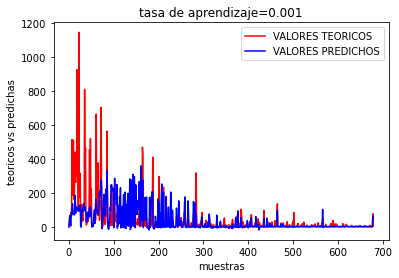

Para 0.01 Error de validación: 1397291.6705882356 +/- 2222712.552211642
Para 0.01 Error de validación minimo: 18652.378676470587


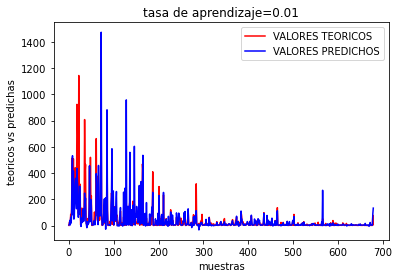

Para 0.1 Error de validación: 1143089.928998162 +/- 1846803.7815598813
Para 0.1 Error de validación minimo: 6330.899356617647


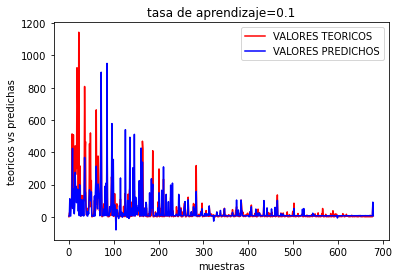

In [29]:
#FEED FORWARD NEURAL NETWORK
def ECM(Y_real,Y_est):
    N = np.size(Y_real)
    ecm = np.sum((Y_est - Y_real)**2)/N
    return ecm




model = keras.Sequential()
model.add(keras.Input(25))
model.add(Dense(20, activation="relu"))#eran 20
model.add(Dense(10, activation="relu"))#eran 10
model.add(Dense(1, activation="linear"))
db = np.asarray(db).astype(np.float32)
Y = np.asarray(Y).astype(np.float32)
#print(db[1,:])
#print(np.shape(db))
#print(db[1,:])
#Implemetamos la metodología de validación cross validation con 10 folds
kf = KFold(n_splits=10)
#predichas=np.ones((np.size(X,0),1))
etas=[0.001,0.01,0.1]#[0.001,0.1]
epochs=[100]#[100,1000]
for epoch in epochs:
    resultados=[]
    print("Epoch "+str(epoch)+":")
    for eta in etas:
        j=0
        predichas=np.ones((np.size(db,0),1))
        Errores = np.ones(10)
        for train_index, test_index in kf.split(db):
            X_train, X_test = db[train_index], db[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            #opt=keras.rmsprop(lr=eta, rho=0.9, epsilon=1e-08, decay=0.0)
            opt = tf.keras.optimizers.RMSprop(learning_rate=eta)
            #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='mse',optimizer=opt)#"RMSprop")
            # Complete el código para entrenar el modelo
            model.fit(X_train,y_train, epochs=epoch, batch_size=68,verbose=0)
            y_pred = model.predict(X_test)
            #predichas[test_index]=y_pred
            #print("son entonces:")
            #print(type(y_test))
            #print(type(y_pred))
            #print(ECM(y_test,y_pred))
            predichas[test_index]=y_pred
            Errores[j] =ECM(y_test,y_pred)
            j+=1
        #print(np.zeros((100,100)))
        print("Para "+str(eta)+" Error de validación: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))
        print("Para "+str(eta)+" Error de validación minimo: " + str(np.amin(Errores)))
        resultados.append(np.amin(Errores))
        x=np.size(Y)
        plt.title("tasa de aprendizaje="+str(eta))
        plt.plot(np.arange(x), Y, color="red", label ='VALORES TEORICOS')
        plt.plot(np.arange(x), predichas,color="blue", label ='VALORES PREDICHOS')
        plt.xlabel("muestras")
        plt.ylabel("teoricos vs predichas")
        plt.legend()
        plt.show()
    #ejex = np.array(etas)
    #ejey = np.array(resultados)
    #plt.plot(ejex,ejey,label="epoch "+str(epoch))
#plt.ylabel("ECM minimo")
#plt.xlabel("Eta")
#plt.legend()
#plt.show()

con ccp-prunnign=0.2 random state=11 impureza=1.2 ECM:15952.630998046836 +/- 22174.502645891163


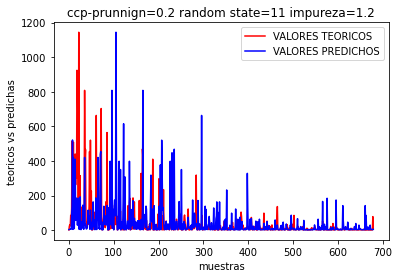

In [33]:
#DESITION TREE REGRESSION
Errores = np.zeros(10)
kf = KFold(n_splits=10)
before=float('inf')
predichas=np.ones((np.size(db,0),1))
impuritydec=[1.2]#np.arange(0.0,2.0,0.1).tolist()
ccp=[0.2]#np.arange(0.0,2.0,0.1).tolist()
randome=[11]#np.arange(0,20,1).tolist()
for im in impuritydec:
    for c in ccp:
        for r in randome:
            j=0
            
            for train_index, test_index in kf.split(db):
                clf=DecisionTreeRegressor(criterion='friedman_mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=r, max_leaf_nodes=None, min_impurity_decrease=im, ccp_alpha=c).fit(db[train_index],Y[train_index])
                Y_est = clf.predict(db[test_index]) 
                predichas[test_index]=Y_est.reshape(np.size(Y_est,0),1)
                y_test=Y[test_index]
                Errores[j] = ECM(Y_est, y_test)
                j+=1
            if(np.mean(Errores)<before):
                before=np.mean(Errores)
                print ("con ccp-prunnign="+str(c)+" random state="+str(r)+" impureza="+str(im)+" ECM:"+str(np.mean(Errores))+" +/- "+str(np.std(Errores)))
x=np.size(Y)
plt.title("ccp-prunnign="+str(c)+" random state="+str(r)+" impureza="+str(im))
plt.plot(np.arange(x), Y, color="red", label ='VALORES TEORICOS')
plt.plot(np.arange(x), predichas,color="blue", label ='VALORES PREDICHOS')
plt.xlabel("muestras")
plt.ylabel("teoricos vs predichas")
plt.legend()
plt.show()  


In [66]:
#SUPPOR VECTOR MACHINE
#Error cuadrático medio (para problemas de regresión)
def ECM(Y_est,Y_real):
    N = np.size(Y_real)
    ecm = sum((Y_est - Y_real)**2)/N
    return ecm 


tiempo_i = time.time()
gamma=np.arange(0.001,1,0.001).tolist()#[0.0001,0.001,0.01,0.1]#1/radio de un vector de soporte
C=np.arange(1,100,1).tolist()#[1,10,100,100]#penalizar funcion de costo por muestras que caen en la calle
for c in C:
    for g in gamma:
        clf = svm.SVR(kernel='rbf',gamma=g,C=c)
        Errores = np.ones(10)
        j = 0
        kf = KFold(n_splits=10)
        predichas=np.zeros((np.size(db,0),1))
        for train_index, test_index in kf.split(db):
            X_train, X_test = db[train_index],db[test_index]
            y_train, y_test = Y[train_index], Y[test_index]  
            modelo=clf.fit(X_train,y_train)
            ypred = modelo.predict(X_test)
            Errores[j] = ECM(ypred, y_test)
            ypred=ypred.reshape((np.size(ypred,0),1))
            predichas[test_index]=ypred
            j+=1
        if(np.mean(Errores)<8000):
            print("con C="+str(c)+" ,gamma="+str(g)+" Error de validación: " + str(np.mean(Errores)) + " +/- " + str(np.std(Errores)))
            x=np.size(Y)
            #plt.title("ccp-prunnign="+str(c)+" random state="+str(r)+" impureza="+str(im))
            plt.plot(np.arange(x), Y, color="red", label ='VALORES TEORICOS')
            plt.plot(np.arange(x), predichas,color="blue", label ='VALORES PREDICHOS')
            plt.xlabel("muestras")
            plt.ylabel("teoricos vs predichas")
            plt.legend()
            plt.show()

KeyboardInterrupt: 

TypeError: arange() argument after * must be an iterable, not int